# General Imports

In [9]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [10]:
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns

In [11]:
from icecream import ic

In [12]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision import transforms as transform_lib
from pytorch_lightning.callbacks import TQDMProgressBar
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from dropblock import DropBlock2D

In [13]:
from dataset.cityscapes import Cityscapes
from dataset.cityscapes import CityscapesDataModule
from dataset.woodscape import WoodScapeDataset
from dataset.woodscape import WoodScapeDataModule
from dataset import WoodScapeSoilingDataset
from dataset import WoodScapeSoilingDataModule

In [14]:
from dataset.cityscapes import Cityscapes
from dataset.cityscapes import CityscapesDataModule
from dataset.woodscape import WoodScapeDataset
from dataset.woodscape import WoodScapeDataModule
from dataset import WoodScapeSoilingDataset
from dataset import WoodScapeSoilingDataModule

In [15]:
from utils.display_images import denormalize_img
from utils import show_dataset_image, show_dataset_mask
from utils import show_prediction_images, show_prediction_uncertainty_images

In [16]:
from deeplab_v3p import DeepLabV3PlusModule
from dropblock import DropBlock2D

In [17]:
from ls_ood_detect.uncertainty_estimation import Hook
from ls_ood_detect.uncertainty_estimation import deeplabv3p_get_ls_mcd_samples
from ls_ood_detect.uncertainty_estimation import get_latent_represent_mcd_samples
from ls_ood_detect.uncertainty_estimation import get_dl_h_z
from ls_ood_detect.ood_detection_dataset import build_ood_detection_ds
from ls_ood_detect.dimensionality_reduction import plot_samples_pacmap
from ls_ood_detect.detectors import KDEClassifier, DetectorKDE
from ls_ood_detect.score import get_hz_scores
from ls_ood_detect.metrics import get_hz_detector_results
from ls_ood_detect.metrics import get_ood_detector_results
from ls_ood_detect.metrics import plot_roc_ood_detector
from ls_ood_detect.metrics import plot_auprc_ood_detector
from ls_ood_detect.dimensionality_reduction import plot_samples_pacmap
from ls_ood_detect.dimensionality_reduction import apply_pca_ds_split
from ls_ood_detect.dimensionality_reduction import apply_pca_transform

# Load Entropy

In [18]:
data_path = "./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/deeplabv3p-cityscapes/embeddings/cityscapes/entropy/"

In [19]:
cs_dlv3p_h_z_cs_normal_train_samples_np = np.load(data_path + 'cs_dlv3p_h_z_cs_normal_train_samples_np.npy')
cs_dlv3p_h_z_cs_normal_valid_samples_np = np.load(data_path + 'cs_dlv3p_h_z_cs_normal_valid_samples_np.npy')
cs_dlv3p_h_z_cs_normal_test_samples_np = np.load(data_path + 'cs_dlv3p_h_z_cs_normal_test_samples_np.npy')

cs_dlv3p_h_z_cs_anomal_valid_samples_np = np.load(data_path + 'cs_dlv3p_h_z_cs_anomal_valid_samples_np.npy')
cs_dlv3p_h_z_cs_anomal_test_samples_np = np.load(data_path + 'cs_dlv3p_h_z_cs_anomal_test_samples_np.npy')

cs_dlv3p_h_z_ws_256512_valid_samples_np = np.load(data_path + 'cs_dlv3p_h_z_ws_256512_valid_samples_np.npy')
cs_dlv3p_h_z_ws_256512_test_samples_np = np.load(data_path + 'cs_dlv3p_h_z_ws_256512_test_samples_np.npy')

cs_dlv3p_h_z_ws_soil_256512_valid_samples_np = np.load(data_path + 'cs_dlv3p_h_z_ws_soil_256512_valid_samples_np.npy')
cs_dlv3p_h_z_ws_soil_256512_test_samples_np = np.load(data_path + 'cs_dlv3p_h_z_ws_soil_256512_test_samples_np.npy')

# Build Deeplabv3+ Cityscapes LaRED Distribution Shift Detector

In [21]:
ic(cs_dlv3p_h_z_cs_normal_train_samples_np.shape);
ic(cs_dlv3p_h_z_cs_normal_valid_samples_np.shape);
ic(cs_dlv3p_h_z_cs_normal_test_samples_np.shape);

ic(cs_dlv3p_h_z_cs_anomal_valid_samples_np.shape);
ic(cs_dlv3p_h_z_cs_anomal_test_samples_np.shape);

ic(cs_dlv3p_h_z_ws_256512_valid_samples_np.shape);
ic(cs_dlv3p_h_z_ws_256512_test_samples_np.shape);

ic(cs_dlv3p_h_z_ws_soil_256512_valid_samples_np.shape);
ic(cs_dlv3p_h_z_ws_soil_256512_test_samples_np.shape);

ic| cs_dlv3p_h_z_cs_normal_train_samples_np.shape: (2975, 2048)
ic| cs_dlv3p_h_z_cs_normal_valid_samples_np

.shape: (500, 2048)
ic| cs_dlv3p_h_z_cs_normal_test_samples_np.shape: (1525, 2048)
ic| cs_dlv3p_h_z_cs_anomal_valid_samples_np.shape: (500, 2048)
ic| cs_dlv3p_h_z_cs_anomal_test_samples_np.shape: (1525, 2048)
ic| cs_dlv3p_h_z_ws_256512_valid_samples_np.shape: (1482, 2048)
ic| cs_dlv3p_h_z_ws_256512_test_samples_np.shape: (823, 2048)
ic| cs_dlv3p_h_z_ws_soil_256512_valid_samples_np.shape: (800, 2048)
ic| cs_dlv3p_h_z_ws_soil_256512_test_samples_np.shape: (1000, 2048)


## PCA Dimensionality Reduction

In [22]:
pca_cs_dlv3p_h_z_cs_normal_train_samples_np, pca_tr = apply_pca_ds_split(samples=cs_dlv3p_h_z_cs_normal_train_samples_np,
                                                                         nro_components=58)

In [23]:
pca_cs_dlv3p_h_z_cs_normal_valid_samples_np = apply_pca_transform(cs_dlv3p_h_z_cs_normal_valid_samples_np, pca_tr) # InD
pca_cs_dlv3p_h_z_cs_normal_test_samples_np = apply_pca_transform(cs_dlv3p_h_z_cs_normal_test_samples_np, pca_tr) # InD

pca_cs_dlv3p_h_z_cs_anomal_valid_samples_np= apply_pca_transform(cs_dlv3p_h_z_cs_anomal_valid_samples_np, pca_tr) # OoD | Anomaly
pca_cs_dlv3p_h_z_cs_anomal_test_samples_np = apply_pca_transform(cs_dlv3p_h_z_cs_anomal_test_samples_np, pca_tr) # OoD | Anomaly

pca_cs_dlv3p_h_z_ws_256512_valid_samples_np = apply_pca_transform(cs_dlv3p_h_z_ws_256512_valid_samples_np, pca_tr) # OoD | Anomaly
pca_cs_dlv3p_h_z_ws_256512_test_samples_np = apply_pca_transform(cs_dlv3p_h_z_ws_256512_test_samples_np, pca_tr) # OoD | Anomaly

pca_cs_dlv3p_h_z_ws_soil_256512_valid_samples_np = apply_pca_transform(cs_dlv3p_h_z_ws_soil_256512_valid_samples_np, pca_tr) # OoD | Anomaly
pca_cs_dlv3p_h_z_ws_soil_256512_test_samples_np = apply_pca_transform(cs_dlv3p_h_z_ws_soil_256512_test_samples_np, pca_tr) # OoD | Anomaly

In [24]:
ic(pca_cs_dlv3p_h_z_cs_normal_train_samples_np.shape);
ic(pca_cs_dlv3p_h_z_cs_normal_valid_samples_np.shape);
ic(pca_cs_dlv3p_h_z_cs_normal_test_samples_np.shape);

ic(pca_cs_dlv3p_h_z_cs_anomal_valid_samples_np.shape);
ic(pca_cs_dlv3p_h_z_cs_anomal_test_samples_np.shape);

ic(pca_cs_dlv3p_h_z_ws_256512_valid_samples_np.shape);
ic(pca_cs_dlv3p_h_z_ws_256512_test_samples_np.shape);

ic(pca_cs_dlv3p_h_z_ws_soil_256512_valid_samples_np.shape);
ic(pca_cs_dlv3p_h_z_ws_soil_256512_test_samples_np.shape);

ic| pca_cs_dlv3p_h_z_cs_normal_train_samples_np.shape: (2975, 58)
ic| pca_cs_dlv3p_h_z_cs_normal_valid_samples_np.shape: (500, 58)
ic| pca_cs_dlv3p_h_z_cs_normal_test_samples_np.shape: (1525, 58)
ic| pca_cs_dlv3p_h_z_cs_anomal_valid_samples_np

.shape: (500, 58)
ic| pca_cs_dlv3p_h_z_cs_anomal_test_samples_np.shape: (1525, 58)
ic| pca_cs_dlv3p_h_z_ws_256512_valid_samples_np.shape: (1482, 58)
ic| pca_cs_dlv3p_h_z_ws_256512_test_samples_np.shape: (823, 58)
ic| pca_cs_dlv3p_h_z_ws_soil_256512_valid_samples_np.shape: (800, 58)
ic| pca_cs_dlv3p_h_z_ws_soil_256512_test_samples_np.shape: (1000, 58)


## Build Detector

In [25]:
cs_dlv3p_ds_shift_detector = DetectorKDE(train_embeddings=pca_cs_dlv3p_h_z_cs_normal_train_samples_np)

In [26]:
scores_pca_cs_dlv3p_h_z_cs_normal_valid_samples_np = get_hz_scores(cs_dlv3p_ds_shift_detector,
                                                                  pca_cs_dlv3p_h_z_cs_normal_valid_samples_np)

scores_pca_cs_dlv3p_h_z_cs_normal_test_samples_np = get_hz_scores(cs_dlv3p_ds_shift_detector,
                                                                  pca_cs_dlv3p_h_z_cs_normal_test_samples_np)


scores_pca_cs_dlv3p_h_z_cs_anomal_valid_samples_np = get_hz_scores(cs_dlv3p_ds_shift_detector,
                                                                   pca_cs_dlv3p_h_z_cs_anomal_valid_samples_np)

scores_pca_cs_dlv3p_h_z_cs_anomal_test_samples_np = get_hz_scores(cs_dlv3p_ds_shift_detector,
                                                                  pca_cs_dlv3p_h_z_cs_anomal_test_samples_np)


scores_pca_cs_dlv3p_h_z_ws_256512_valid_samples_np = get_hz_scores(cs_dlv3p_ds_shift_detector,
                                                                   pca_cs_dlv3p_h_z_ws_256512_valid_samples_np)

scores_pca_cs_dlv3p_h_z_ws_256512_test_samples_np = get_hz_scores(cs_dlv3p_ds_shift_detector,
                                                                  pca_cs_dlv3p_h_z_ws_256512_test_samples_np)


scores_pca_cs_dlv3p_h_z_ws_soil_256512_valid_samples_np = get_hz_scores(cs_dlv3p_ds_shift_detector,
                                                                        pca_cs_dlv3p_h_z_ws_soil_256512_valid_samples_np)

scores_pca_cs_dlv3p_h_z_ws_soil_256512_test_samples_np = get_hz_scores(cs_dlv3p_ds_shift_detector,
                                                                       pca_cs_dlv3p_h_z_ws_soil_256512_test_samples_np)


In [30]:
scores_pca_cs_dlv3p_ind_cs_normal_h_z = np.concatenate((scores_pca_cs_dlv3p_h_z_cs_normal_valid_samples_np,
                                                        scores_pca_cs_dlv3p_h_z_cs_normal_test_samples_np))

scores_pca_cs_dlv3p_ood_cs_anomal_h_z = np.concatenate((scores_pca_cs_dlv3p_h_z_cs_anomal_valid_samples_np,
                                                        scores_pca_cs_dlv3p_h_z_cs_anomal_test_samples_np))

scores_pca_cs_dlv3p_ood_ws_h_z = np.concatenate((scores_pca_cs_dlv3p_h_z_ws_256512_valid_samples_np,
                                                 scores_pca_cs_dlv3p_h_z_ws_256512_test_samples_np))

scores_pca_cs_dlv3p_ood_ws_soil_h_z = np.concatenate((scores_pca_cs_dlv3p_h_z_ws_soil_256512_valid_samples_np,
                                                      scores_pca_cs_dlv3p_h_z_ws_soil_256512_test_samples_np))

ic(scores_pca_cs_dlv3p_ind_cs_normal_h_z.shape);
ic(scores_pca_cs_dlv3p_ood_cs_anomal_h_z.shape);
ic(scores_pca_cs_dlv3p_ood_ws_h_z.shape);
ic(scores_pca_cs_dlv3p_ood_ws_soil_h_z.shape);

ic| scores_pca_cs_dlv3p_ind_cs_normal_h_z.shape: (2025,)
ic| scores_pca_cs_dlv3p_ood_cs_anomal_h_z.shape: (2025,)


ic| scores_pca_cs_dlv3p_ood_ws_h_z.shape: (2305,)
ic| scores_pca_cs_dlv3p_ood_ws_soil_h_z.shape: (1800,)


In [31]:
ic(scores_pca_cs_dlv3p_ind_cs_normal_h_z.shape);
ic(scores_pca_cs_dlv3p_ood_cs_anomal_h_z.shape);

results_ws_anomal = get_hz_detector_results(detect_exp_name="cityscapes vs. cityscapes-anomalies",
                                            ind_samples_scores=scores_pca_cs_dlv3p_ind_cs_normal_h_z,
                                            ood_samples_scores=scores_pca_cs_dlv3p_ood_cs_anomal_h_z)

ic| scores_pca_cs_dlv3p_ind_cs_normal_h_z.shape: (2025,)
ic| scores_pca_cs_dlv3p_ood_cs_anomal_h_z.shape: (2025,)


AUROC: 0.9248
FPR95: 0.3501
AUPR: 0.9220


In [32]:
ic(scores_pca_cs_dlv3p_ind_cs_normal_h_z.shape);
ic(scores_pca_cs_dlv3p_ood_ws_h_z.shape);

results_cs = get_hz_detector_results(detect_exp_name="cityscapes vs. woodscape",
                                     ind_samples_scores=scores_pca_cs_dlv3p_ind_cs_normal_h_z,
                                     ood_samples_scores=scores_pca_cs_dlv3p_ood_ws_h_z)

ic| scores_pca_cs_dlv3p_ind_cs_normal_h_z.shape: (2025,)
ic| scores_pca_cs_dlv3p_ood_ws_h_z.shape: (2305,)


AUROC: 0.9931
FPR95: 0.0065
AUPR: 0.9939


In [33]:
ic(scores_pca_cs_dlv3p_ind_cs_normal_h_z.shape);
ic(scores_pca_cs_dlv3p_ood_ws_soil_h_z.shape);

results_ws_soil = get_hz_detector_results(detect_exp_name="cityscapes vs. woodscape-soiling",
                                          ind_samples_scores=scores_pca_cs_dlv3p_ind_cs_normal_h_z,
                                          ood_samples_scores=scores_pca_cs_dlv3p_ood_ws_soil_h_z)

ic| scores_pca_cs_dlv3p_ind_cs_normal_h_z.shape: (2025,)
ic| scores_pca_cs_dlv3p_ood_ws_soil_h_z.shape: (1800,)


AUROC: 0.9963
FPR95: 0.0000
AUPR: 0.9973


## Plot scores

In [294]:
df_score_ind_ws_normal = pd.DataFrame(scores_pca_cs_dlv3p_ind_cs_normal_h_z, columns=["LaRED score"])
df_score_ood_ws_anomal = pd.DataFrame(scores_pca_cs_dlv3p_ood_cs_anomal_h_z, columns=["LaRED score"])
df_score_ood_cs = pd.DataFrame(scores_pca_cs_dlv3p_ood_ws_h_z, columns=["LaRED score"])
df_score_ood_ws_soil = pd.DataFrame(scores_pca_cs_dlv3p_ood_ws_soil_h_z, columns=["LaRED score"])

df_score_ind_ws_normal.insert(0, "Dataset", "")
df_score_ind_ws_normal.loc[:, "Dataset"] = "InD-cityscapes-normal"

df_score_ood_ws_anomal.insert(0, "Dataset", "")
df_score_ood_ws_anomal.loc[:, "Dataset"] = "cityscapes-anomalies"

df_score_ood_cs.insert(0, "Dataset", "")
df_score_ood_cs.loc[:, "Dataset"] = "woodscape"

df_score_ood_ws_soil.insert(0, "Dataset", "")
df_score_ood_ws_soil.loc[:, "Dataset"] = "woodscape-soiling"

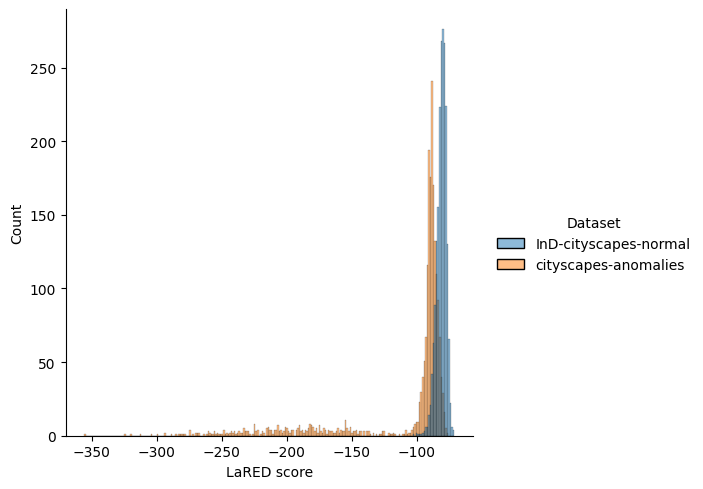

In [296]:
df_h_z_valid_scores = pd.concat([df_score_ind_ws_normal,
                                 df_score_ood_ws_anomal]).reset_index(drop=True)

sns.displot(df_h_z_valid_scores, x="LaRED score", hue="Dataset", kind="hist", fill=True)
plt.show()

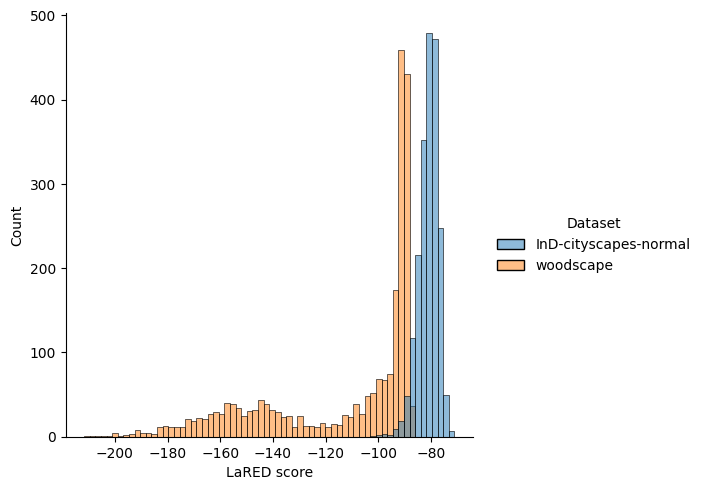

In [297]:
df_h_z_valid_scores = pd.concat([df_score_ind_ws_normal,
                                 df_score_ood_cs]).reset_index(drop=True)

sns.displot(df_h_z_valid_scores, x="LaRED score", hue="Dataset", kind="hist", fill=True)
plt.show()

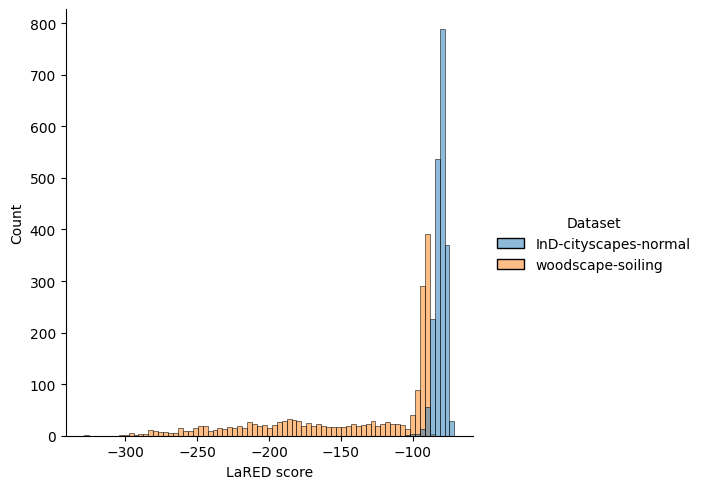

In [298]:
df_h_z_valid_scores = pd.concat([df_score_ind_ws_normal,
                                 df_score_ood_ws_soil]).reset_index(drop=True)

sns.displot(df_h_z_valid_scores, x="LaRED score", hue="Dataset", kind="hist", fill=True)
plt.show()

So far, the best results are obtained with 58 PCA components

# Load Entropy

In [103]:
data_path = "./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/deeplabv3p-cityscapes/embeddings/cityscapes/entropy/"

In [104]:
cs_dlv3p_h_z_cs_normal_train_samples_np = np.load(data_path + 'cs_dlv3p_h_z_cs_normal_train_samples_np.npy')
cs_dlv3p_h_z_cs_normal_valid_samples_np = np.load(data_path + 'cs_dlv3p_h_z_cs_normal_valid_samples_np.npy')
cs_dlv3p_h_z_cs_normal_test_samples_np = np.load(data_path + 'cs_dlv3p_h_z_cs_normal_test_samples_np.npy')

cs_dlv3p_h_z_cs_anomal_valid_samples_np = np.load(data_path + 'cs_dlv3p_h_z_cs_anomal_valid_samples_np.npy')
cs_dlv3p_h_z_cs_anomal_test_samples_np = np.load(data_path + 'cs_dlv3p_h_z_cs_anomal_test_samples_np.npy')

cs_dlv3p_h_z_ws_256512_valid_samples_np = np.load(data_path + 'cs_dlv3p_h_z_ws_256512_valid_samples_np.npy')
cs_dlv3p_h_z_ws_256512_test_samples_np = np.load(data_path + 'cs_dlv3p_h_z_ws_256512_test_samples_np.npy')

cs_dlv3p_h_z_ws_soil_256512_valid_samples_np = np.load(data_path + 'cs_dlv3p_h_z_ws_soil_256512_valid_samples_np.npy')
cs_dlv3p_h_z_ws_soil_256512_test_samples_np = np.load(data_path + 'cs_dlv3p_h_z_ws_soil_256512_test_samples_np.npy')

# Build Deeplabv3+-Cityscapes LaREM Distribution Shift Detector 

In [39]:
ic(cs_dlv3p_h_z_cs_normal_train_samples_np.shape);
ic(cs_dlv3p_h_z_cs_normal_valid_samples_np.shape);
ic(cs_dlv3p_h_z_cs_normal_test_samples_np.shape);

ic(cs_dlv3p_h_z_cs_anomal_valid_samples_np.shape);
ic(cs_dlv3p_h_z_cs_anomal_test_samples_np.shape);

ic(cs_dlv3p_h_z_ws_256512_valid_samples_np.shape);
ic(cs_dlv3p_h_z_ws_256512_test_samples_np.shape);

ic(cs_dlv3p_h_z_ws_soil_256512_valid_samples_np.shape);
ic(cs_dlv3p_h_z_ws_soil_256512_test_samples_np.shape);

ic| cs_dlv3p_h_z_cs_normal_train_samples_np.shape: (2975, 2048)
ic| cs_dlv3p_h_z_cs_normal_valid_samples_np.shape: (500, 2048)
ic| cs_dlv3p_h_z_cs_normal_test_samples_np.shape: (1525,

 2048)
ic| cs_dlv3p_h_z_cs_anomal_valid_samples_np.shape: (500, 2048)
ic| cs_dlv3p_h_z_cs_anomal_test_samples_np.shape: (1525, 2048)
ic| cs_dlv3p_h_z_ws_256512_valid_samples_np.shape: (1482, 2048)
ic| cs_dlv3p_h_z_ws_256512_test_samples_np.shape: (823, 2048)
ic| cs_dlv3p_h_z_ws_soil_256512_valid_samples_np.shape: (800, 2048)
ic| cs_dlv3p_h_z_ws_soil_256512_test_samples_np.shape: (1000, 2048)


## Build Detector LaREMd

In [40]:
from sklearn.covariance import EmpiricalCovariance

class LaREMPostprocessor:
    def __init__(self,
                 setup_flag: bool = False,
                 get_2d_rep_mean: bool = False):

        self.setup_flag = setup_flag
        self.get_2d_rep_mean = get_2d_rep_mean
        self.feats_mean = None
        self.precision = None

    def setup(self,
              ind_feats: np.ndarray):
        
        if not self.setup_flag:
            # estimate mean and variance from training set
            print('\n Estimating mean and variance from training set...')

            self.feats_mean = ind_feats.mean(0)
            self.feats_mean = np.mean(ind_feats, 0, keepdims=True)
            
            self.centered_data = ind_feats - self.feats_mean
              
            group_lasso = EmpiricalCovariance(assume_centered=False)
            group_lasso.fit(self.centered_data)
            
            self.precision = group_lasso.precision_
            
            self.setup_flag = True
            # we need to use:
            # self.feats_mean & self.precision
        else:
            pass

    def postprocess(self,
                    ood_feats: np.ndarray):
           
        diff = ood_feats - self.feats_mean
        conf_score = -np.diag(np.matmul(np.matmul(diff, self.precision), np.transpose(diff)))

        return conf_score

In [41]:
cs_dlv3p_larem_detector = LaREMPostprocessor()

In [42]:
cs_dlv3p_larem_detector.setup(cs_dlv3p_h_z_cs_normal_train_samples_np)


 Estimating mean and variance from training set...


In [43]:
ic(cs_dlv3p_larem_detector.feats_mean.shape);
ic(cs_dlv3p_larem_detector.precision.shape);

ic| cs_dlv3p_larem_detector.feats_mean.shape: (1, 2048)
ic| cs_dlv3p_larem_detector.precision.shape: (2048, 2048)


In [54]:
ind_cs_valid_larem_score = cs_dlv3p_larem_detector.postprocess(cs_dlv3p_h_z_cs_normal_valid_samples_np)
ic(ind_cs_valid_larem_score.shape);
ind_cs_test_larem_score = cs_dlv3p_larem_detector.postprocess(cs_dlv3p_h_z_cs_normal_test_samples_np)
ic(ind_cs_test_larem_score.shape);


ood_cs_anomal_valid_larem_score = cs_dlv3p_larem_detector.postprocess(cs_dlv3p_h_z_cs_anomal_valid_samples_np)
ic(ood_cs_anomal_valid_larem_score.shape);
ood_cs_anomal_test_larem_score = cs_dlv3p_larem_detector.postprocess(cs_dlv3p_h_z_cs_anomal_test_samples_np)
ic(ood_cs_anomal_test_larem_score.shape);


ood_ws_valid_larem_score = cs_dlv3p_larem_detector.postprocess(cs_dlv3p_h_z_ws_256512_valid_samples_np)
ic(ood_ws_valid_larem_score.shape);
ood_ws_test_larem_score = cs_dlv3p_larem_detector.postprocess(cs_dlv3p_h_z_ws_256512_test_samples_np)
ic(ood_ws_test_larem_score.shape);


ood_ws_soil_valid_larem_score = cs_dlv3p_larem_detector.postprocess(cs_dlv3p_h_z_ws_soil_256512_valid_samples_np)
ic(ood_ws_soil_valid_larem_score.shape);
ood_ws_soil_test_larem_score = cs_dlv3p_larem_detector.postprocess(cs_dlv3p_h_z_ws_soil_256512_test_samples_np)
ic(ood_ws_soil_test_larem_score.shape);

ic| ind_cs_valid_larem_score.shape: (500,)
ic| ind_cs_test_larem_score.shape: (1525,)
ic| ood_cs_anomal_valid_larem_score.shape: (500,)
ic| ood_cs_anomal_test_larem_score.shape: (1525,)
ic| ood_ws_valid_larem_score.shape: (1482,)
ic| ood_ws_test_larem_score.shape: (823,)
ic| ood_ws_soil_valid_larem_score.shape: (800,)
ic| ood_ws_soil_test_larem_score.shape: (1000,)


In [55]:
cs_dlv3p_ind_cs_larem_scores = np.concatenate((ind_cs_valid_larem_score,
                                                        ind_cs_test_larem_score))

cs_dlv3p_ood_cs_anomal_larem_scores = np.concatenate((ood_cs_anomal_valid_larem_score,
                                                      ood_cs_anomal_test_larem_score))

cs_dlv3p_ood_ws_larem_scores = np.concatenate((ood_ws_valid_larem_score,
                                               ood_ws_test_larem_score))

cs_dlv3p_ood_ws_soil_larem_scores = np.concatenate((ood_ws_soil_valid_larem_score,
                                                    ood_ws_soil_test_larem_score))

ic(cs_dlv3p_ind_cs_larem_scores.shape);
ic(cs_dlv3p_ood_cs_anomal_larem_scores.shape);
ic(cs_dlv3p_ood_ws_larem_scores.shape);
ic(cs_dlv3p_ood_ws_soil_larem_scores.shape);

ic| cs_dlv3p_ind_cs_larem_scores.shape: (2025,)


ic| cs_dlv3p_ood_cs_anomal_larem_scores.shape: (2025,)
ic| cs_dlv3p_ood_ws_larem_scores.shape: (2305,)
ic| cs_dlv3p_ood_ws_soil_larem_scores.shape: (1800,)


In [56]:
ic(cs_dlv3p_ind_cs_larem_scores.shape);
ic(cs_dlv3p_ood_cs_anomal_larem_scores.shape);

results_ws_anomal = get_hz_detector_results(detect_exp_name="cityscapes vs. cityscapes-anomalies",
                                            ind_samples_scores=cs_dlv3p_ind_cs_larem_scores,
                                            ood_samples_scores=cs_dlv3p_ood_cs_anomal_larem_scores)

ic| cs_dlv3p_ind_cs_larem_scores.shape: (2025,)
ic| cs_dlv3p_ood_cs_anomal_larem_scores.shape: (2025,)


AUROC: 0.9826
FPR95: 0.0973
AUPR: 0.9834


In [57]:
ic(cs_dlv3p_ind_cs_larem_scores.shape);
ic(cs_dlv3p_ood_ws_larem_scores.shape);

results_cs = get_hz_detector_results(detect_exp_name="cityscapes vs. woodscape",
                                     ind_samples_scores=cs_dlv3p_ind_cs_larem_scores,
                                     ood_samples_scores=cs_dlv3p_ood_ws_larem_scores)

ic| cs_dlv3p_ind_cs_larem_scores.shape: (2025,)
ic| cs_dlv3p_ood_ws_larem_scores.shape: (2305,)


AUROC: 0.9991
FPR95: 0.0000
AUPR: 0.9991


In [58]:
ic(cs_dlv3p_ind_cs_larem_scores.shape);
ic(cs_dlv3p_ood_ws_soil_larem_scores.shape);

results_ws_soil = get_hz_detector_results(detect_exp_name="cityscapes vs. woodscape-soiling",
                                          ind_samples_scores=cs_dlv3p_ind_cs_larem_scores,
                                          ood_samples_scores=cs_dlv3p_ood_ws_soil_larem_scores)

ic| cs_dlv3p_ind_cs_larem_scores.shape: (2025,)


ic| cs_dlv3p_ood_ws_soil_larem_scores.shape: (1800,)


AUROC: 0.9999
FPR95: 0.0000
AUPR: 1.0000


## Plot scores

In [59]:
df_score_ind_cs_normal = pd.DataFrame(cs_dlv3p_ind_cs_larem_scores, columns=["LaREM score"])
df_score_ood_cs_anomal = pd.DataFrame(cs_dlv3p_ood_cs_anomal_larem_scores, columns=["LaREM score"])
df_score_ood_ws = pd.DataFrame(cs_dlv3p_ood_ws_larem_scores, columns=["LaREM score"])
df_score_ood_ws_soil = pd.DataFrame(cs_dlv3p_ood_ws_soil_larem_scores, columns=["LaREM score"])

df_score_ind_cs_normal.insert(0, "Dataset", "")
df_score_ind_cs_normal.loc[:, "Dataset"] = "InD-cityscapes-normal"

df_score_ood_cs_anomal.insert(0, "Dataset", "")
df_score_ood_cs_anomal.loc[:, "Dataset"] = "cityscapes-anomalies"

df_score_ood_ws.insert(0, "Dataset", "")
df_score_ood_ws.loc[:, "Dataset"] = "woodscape"

df_score_ood_ws_soil.insert(0, "Dataset", "")
df_score_ood_ws_soil.loc[:, "Dataset"] = "woodscape-soiling"

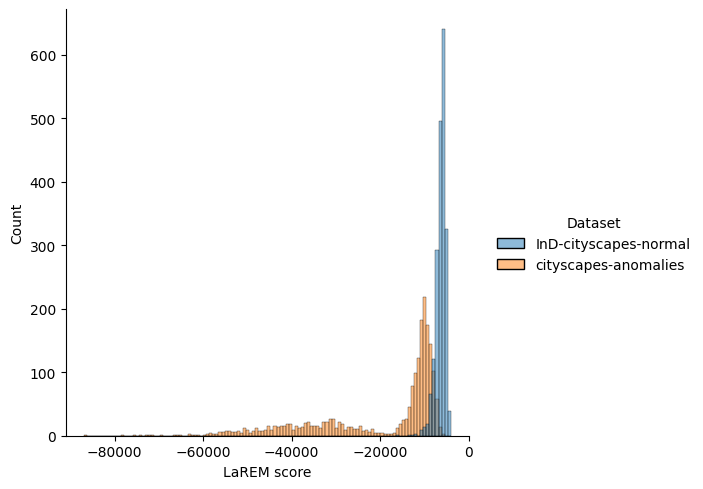

In [64]:
df_larem_scores = pd.concat([df_score_ind_cs_normal,
                             df_score_ood_cs_anomal]).reset_index(drop=True)

sns.displot(df_larem_scores, x="LaREM score", hue="Dataset", kind="hist", fill=True)
plt.show()

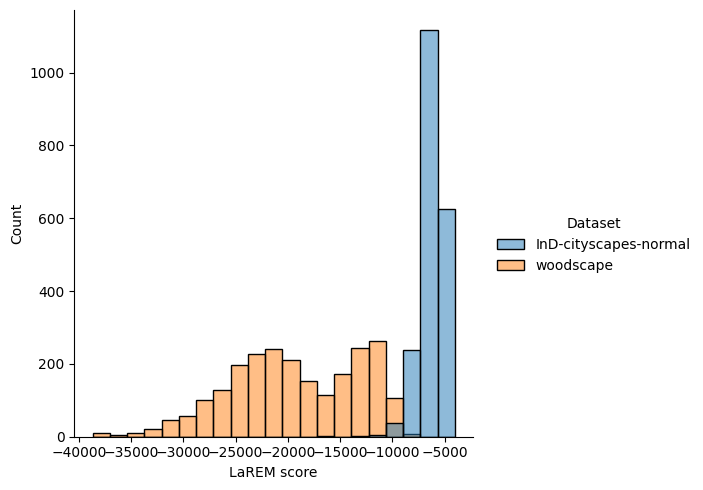

In [65]:
df_larem_scores = pd.concat([df_score_ind_cs_normal,
                             df_score_ood_ws]).reset_index(drop=True)

sns.displot(df_larem_scores, x="LaREM score", hue="Dataset", kind="hist", fill=True)
plt.show()

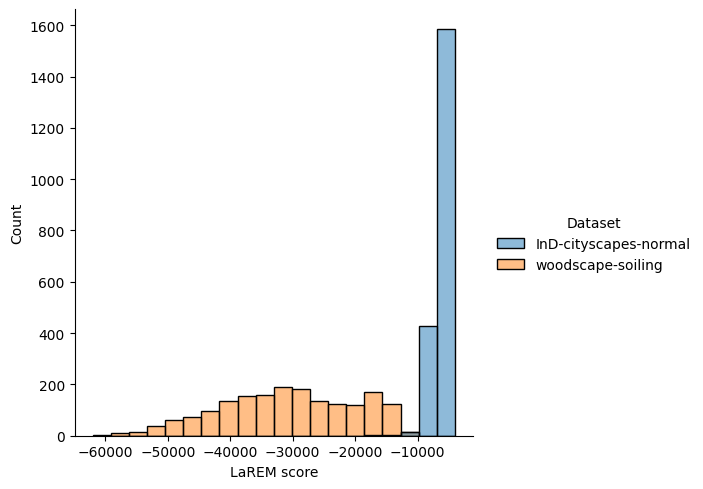

In [66]:
df_larem_scores = pd.concat([df_score_ind_cs_normal,
                             df_score_ood_ws_soil]).reset_index(drop=True)

sns.displot(df_larem_scores, x="LaREM score", hue="Dataset", kind="hist", fill=True)
plt.show()

# Inference Timing

## Dataset Shifted Test Data

### Cityscapes

In [34]:
dataset_path = './Data/DATASETS/CityScapes'
batch_size = 1

In [35]:
cs_dm_normal_dlv3p = CityscapesDataModule(data_dir=dataset_path,
                                          batch_size=batch_size,
                                          target_type='semantic',
                                          img_size=(256, 512),
                                          num_workers=10,
                                          drop_last=True,
                                          default_transforms=False, # Here this should be True!
                                          default_img_mask_transforms=True) # And here this should be False!

In [36]:
cs_dlv3p_train_loader = cs_dm_normal_dlv3p.train_dataloader()
cs_dlv3p_valid_loader = cs_dm_normal_dlv3p.val_dataloader()
cs_dlv3p_test_loader = cs_dm_normal_dlv3p.test_dataloader()

In [37]:
dataiter_cs_valid = iter(cs_dlv3p_valid_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


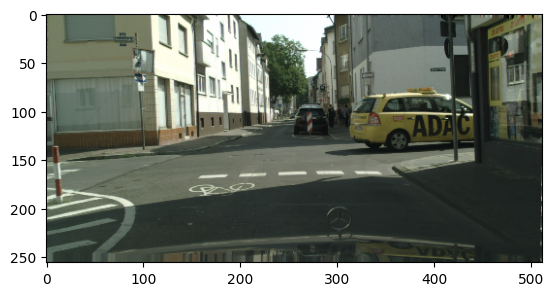

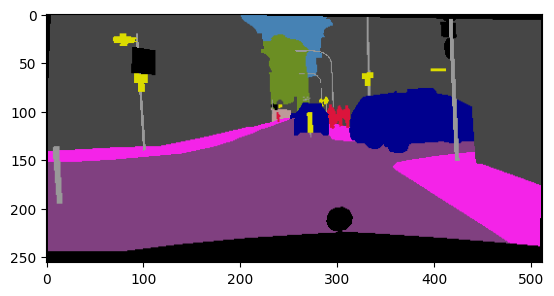

In [38]:
batch_cs_data, batch_cs_labels = dataiter_cs_valid.next()
plt.figure()
show_dataset_image(batch_cs_data[0], cs_dm_normal_dlv3p.norm_mean, cs_dm_normal_dlv3p.norm_std)
plt.figure()
show_dataset_mask(batch_cs_labels[0].squeeze(), cs_dlv3p_train_loader.dataset.decode_target)
plt.show()

### Woodscape

In [44]:
ws_dataset_path = './Data/DATASETS/WoodScape/'
batch_size = 1

cmap = {0: [0, 0, 0],  # "void"
        1: [128, 64, 128],  # "road",
        2: [69, 76, 11],  # "lanemarks",
        3: [0, 255, 0],  # "curb",
        4: [220, 20, 60],  # "person",
        5: [255, 0, 0],  # "rider",
        6: [0, 0, 142],  # "vehicles",
        7: [119, 11, 32],  # "bicycle",
        8: [0, 0, 230],  # "motorcycle",
        9: [220, 220, 0]  # "traffic_sign",
        }

# same values as in VainF Repository! - Probably not the best Values for Woodscapes!
ws_dlv3p_norm_mean = [0.485, 0.456, 0.406]
ws_dlv3p_norm_std = [0.229, 0.224, 0.225]

In [45]:
ws_dm_normal_dlv3p_256_512 = WoodScapeDataModule(dataset_dir=ws_dataset_path,
                                         img_size=(256, 512),
                                         batch_size=batch_size,
                                         default_transforms=True,
                                         label_colours=cmap,
                                         norm_mean=ws_dlv3p_norm_mean,
                                         norm_std=ws_dlv3p_norm_std,
                                         seed=9290,
                                         drop_last=True)
ws_dm_normal_dlv3p_256_512.setup()

DATASET Shuffle Random SEED:  9290


In [46]:
ws_256512_dlv3p_valid_loader = ws_dm_normal_dlv3p_256_512.val_dataloader()
ws_256512_dlv3p_test_loader = ws_dm_normal_dlv3p_256_512.test_dataloader()

In [47]:
dataiter_ws_valid = iter(ws_256512_dlv3p_valid_loader)

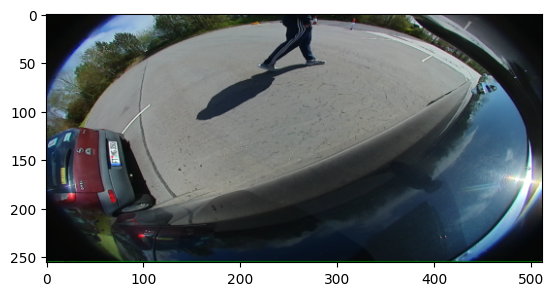

In [48]:
batch_ws_data, batch_ws_labels = dataiter_ws_valid.next()
plt.figure()
show_dataset_image(batch_ws_data[0], ws_dm_normal_dlv3p_256_512.norm_mean, ws_dm_normal_dlv3p_256_512.norm_std)
plt.show()

### Woodscape Anomalies

In [49]:
ws_dlv3p_anomaly_valid_loader = ws_dm_normal_dlv3p_256_512.anomaly_val_dataloader()
ws_dlv3p_anomaly_test_loader = ws_dm_normal_dlv3p_256_512.anomaly_test_dataloader()

In [50]:
dataiter_ws_anomal_valid = iter(ws_dlv3p_anomaly_valid_loader)

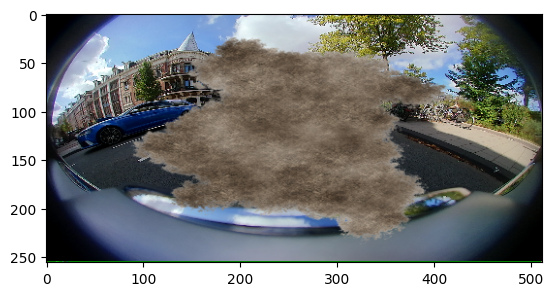

In [54]:
batch_ws_anomal_data, batch_ws_anomal_labels = dataiter_ws_anomal_valid.next()
plt.figure()
show_dataset_image(batch_ws_anomal_data[0], ws_dm_normal_dlv3p_256_512.norm_mean, ws_dm_normal_dlv3p_256_512.norm_std)
plt.show()

### Woodscape-Soiling

In [55]:
woodscape_soil_256512_dm = WoodScapeSoilingDataModule(dataset_dir="./Data/DATASETS/WoodScape/soiling_dataset/",
                                                      img_size=(256, 512),
                                                      batch_size=1,
                                                      default_transforms=True,
                                                      seed=9290)
woodscape_soil_256512_dm.setup()

ic| len(self.rgb_soil_images_list): 4000
ic| len(self.soil_annotations_gt_list): 4000
ic| len(self.soil_annotations_rgb_list): 4000
ic| dataset_train_len: 4000
ic| len(self.rgb_soil_images_list): 1000
ic| len(self.soil_annotations_gt_list): 1000
ic| len(self.soil_annotations_rgb_list): 1000
ic| dataset_test_len: 1000


DATASET Shuffle Random SEED:  9290


In [56]:
ws_soiling_256512_valid_loader = woodscape_soil_256512_dm.val_dataloader()
ws_soiling_256512_test_loader = woodscape_soil_256512_dm.test_dataloader()

In [57]:
dataiter_ws_soiling_valid = iter(ws_soiling_256512_valid_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


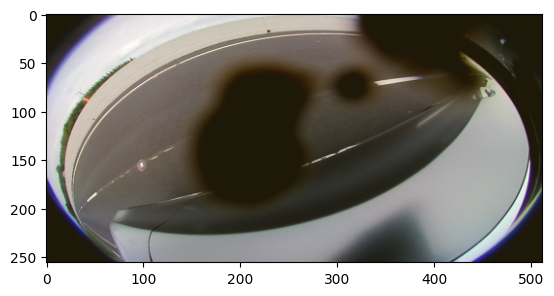

In [60]:
batch_ws_soil_data, batch_ws_soil_labels = dataiter_ws_soiling_valid.next()
plt.figure()
show_dataset_image(batch_ws_soil_data[0], ws_dm_normal_dlv3p_256_512.norm_mean, ws_dm_normal_dlv3p_256_512.norm_std)
plt.show()

In [61]:
batch_ws_soil_data.shape

torch.Size([1, 3, 256, 512])

## Deeplabv3+ Cityscapes Model

In [62]:
cs_dlv3p_path = "./lightning_logs/version_158692/checkpoints/epoch=403-step=18584.ckpt"
cs_dlv3p_model = DeepLabV3PlusModule.load_from_checkpoint(checkpoint_path=cs_dlv3p_path)


In [63]:
ic(cs_dlv3p_model.pred_loss_type);
ic(cs_dlv3p_model.n_class);

ic| cs_dlv3p_model.pred_loss_type: 'focal_loss'
ic| cs_dlv3p_model.n_class: 20


In [64]:
cs_dlv3p_model.eval();

## Deeplabv3+ Woodscape Model

In [18]:
ws_dlv3p_path = "./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/deeplabv3p-woodscape/models/version_66126/checkpoints/last.ckpt"
ws_dlv3p_model = DeepLabV3PlusModule.load_from_checkpoint(checkpoint_path=ws_dlv3p_path)

In [19]:
ic(ws_dlv3p_model.pred_loss_type);
ic(ws_dlv3p_model.n_class);

ic| ws_dlv3p_model.pred_loss_type: 'focal_loss'


ic| ws_dlv3p_model.n_class: 10


In [20]:
ws_dlv3p_model.eval();

In [21]:
ic(ws_dlv3p_model.deeplab_v3plus_model.drop_block1);
ic(ws_dlv3p_model.deeplab_v3plus_model.drop_block1.block_size);
ic(ws_dlv3p_model.deeplab_v3plus_model.drop_block1.drop_prob);
ic(ws_dlv3p_model.deeplab_v3plus_model.drop_block1.training);

ic| ws_dlv3p_model.deeplab_v3plus_model.drop_block1: DropBlock2D()
ic| ws_dlv3p_model.deeplab_v3plus_model.drop_block1.block_size: 8
ic| ws_dlv3p_model.deeplab_v3plus_model.drop_block1.drop_prob: 0.5
ic| ws_dlv3p_model.deeplab_v3plus_model.drop_block1.training: False


## Add Hook

In [65]:
ic(cs_dlv3p_model.deeplab_v3plus_model.drop_block1);
ic(cs_dlv3p_model.deeplab_v3plus_model.drop_block1.block_size);
ic(cs_dlv3p_model.deeplab_v3plus_model.drop_block1.drop_prob);
ic(cs_dlv3p_model.deeplab_v3plus_model.drop_block1.training);

ic| cs_dlv3p_model.deeplab_v3plus_model.drop_block1: DropBlock2D()
ic| cs_dlv3p_model.deeplab_v3plus_model.drop_block1.block_size: 8
ic| cs_dlv3p_model.deeplab_v3plus_model.drop_block1.drop_prob: 0.5


ic| cs_dlv3p_model.deeplab_v3plus_model.drop_block1.training: False


In [66]:
cs_dlv3p_model.deeplab_v3plus_model.backbone.layer4[2]

Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)

In [67]:
cs_dlv3p_model.deeplab_v3plus_model.backbone.layer4[2].relu

ReLU(inplace=True)

In [ ]:
cs_dlv3p_hook_resnet_output = Hook(cs_dlv3p_model.deeplab_v3plus_model.backbone.layer4[2])
cs_dlv3p_hook_resnet_output

## Sampler Module

In [69]:
from dropblock import DropBlock2D

class MCSamplerModule(nn.Module):
    """LeNet Neural Network Architecture
    Author: Andrei Bursuc
    https://github.com/abursuc/dldiy-gtsrb
    """
    def __init__(self, mc_samples=8, get_2d_rep_mean: bool = True):

        super(MCSamplerModule, self).__init__()
        
        self.get_2d_rep_mean = get_2d_rep_mean
        self.mc_samples = mc_samples
        # self.samples = []
        
        self.drop_blocks = nn.ModuleList([DropBlock2D(block_size=8, drop_prob=0.5) for i in range (self.mc_samples)])

    def forward(self, latent_rep):
        samples = []        
        for i, l in enumerate(self.drop_blocks):
            mc_sample = self.drop_blocks[i](latent_rep)
                        
            if self.get_2d_rep_mean:
                # Get image HxW mean:
                mc_sample = torch.mean(mc_sample, dim=2, keepdim=True)
                mc_sample = torch.mean(mc_sample, dim=3, keepdim=True)
                # Remove useless dimensions:
                mc_sample = torch.squeeze(mc_sample, dim=2)
                mc_sample = torch.squeeze(mc_sample, dim=2)
                
            # self.samples.append(mc_sample)
            samples.append(mc_sample)
        # self.samples_t = torch.cat(self.samples)
        self.samples_t = torch.cat(samples)
        return self.samples_t

In [70]:
my_mc_sampler =  MCSamplerModule(mc_samples=16)
my_mc_sampler.drop_blocks
my_mc_sampler.train()

MCSamplerModule(
  (drop_blocks): ModuleList(
    (0): DropBlock2D()
    (1): DropBlock2D()
    (2): DropBlock2D()
    (3): DropBlock2D()
    (4): DropBlock2D()
    (5): DropBlock2D()
    (6): DropBlock2D()
    (7): DropBlock2D()
    (8): DropBlock2D()
    (9): DropBlock2D()
    (10): DropBlock2D()
    (11): DropBlock2D()
    (12): DropBlock2D()
    (13): DropBlock2D()
    (14): DropBlock2D()
    (15): DropBlock2D()
  )
)

In [71]:
my_mc_sampler.drop_blocks[10].training

True

## LaREM Monitor

In [72]:
from time import monotonic
    
def record_time(function):
    def wrap(*args, **kwargs):
        start_time = monotonic()
        function_return = function(*args, **kwargs)
        delta_t = monotonic() - start_time
        # print(f"Run time {monotonic() - start_time} seconds")
        # print(f"Run time {delta_t} seconds")
        return function_return, delta_t
    return wrap

In [73]:
class LaRExMonitor:
    def __init__(self,
                 dnn_model: nn.Module,
                 larem_detector,
                 mcd_samples_nro=16,
                 get_2d_rep_mean=True):
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        self.dnn_model = dnn_model
        self.dnn_model.to(self.device)
        
        self.mcd_samples_nro = mcd_samples_nro
        self.get_2d_rep_mean = get_2d_rep_mean
        self.larem_detector = larem_detector
        
        self.mc_sampler =  MCSamplerModule(mc_samples=self.mcd_samples_nro, get_2d_rep_mean=get_2d_rep_mean)
        self.mc_sampler.to(self.device)
        self.mc_sampler.train()
        
        self.sample_larex_score = None

    @record_time
    def get_larex_score(self,
                        input_image,
                        layer_hook):

        with torch.no_grad():
            input_image = input_image.to(self.device)
            pred_logits = self.dnn_model(input_image)
            latent_rep = layer_hook.output  # latent representation sample
    
        mc_samples_t = self.mc_sampler(latent_rep)
        _, sample_h_z = get_dl_h_z(mc_samples_t, self.mcd_samples_nro)        
        self.sample_larex_score = self.larem_detector.postprocess(sample_h_z)
        return self.sample_larex_score
    
    @record_time
    def get_layer_mc_samples(self,
                             input_image,
                             layer_hook):

        with torch.no_grad():
            input_image = input_image.to(self.device)
            pred_logits = self.dnn_model(input_image)
            latent_rep = layer_hook.output  # latent representation sample
    
        mc_samples_t = self.mc_sampler(latent_rep)
        return mc_samples_t    
    
    @record_time
    def get_mc_samples(self,
                       input_image,
                       layer_hook):
        mc_samples = []
        with torch.no_grad():
            for i in range(self.mcd_samples_nro):
                input_image = input_image.to(self.device)
                pred_logits = self.dnn_model(input_image)
                latent_rep = layer_hook.output    
                mc_samples.append(pred_logits)
            
            mc_samples_t = torch.cat(mc_samples)
            mc_samples_np = mc_samples_t.cpu().numpy()
        return mc_samples_np

In [74]:
cs_dplbv3p_larem_monitor = LaRExMonitor(dnn_model=cs_dlv3p_model.deeplab_v3plus_model,
                                        larem_detector=cs_dlv3p_larem_detector,
                                        mcd_samples_nro=16,
                                        get_2d_rep_mean=True)

In [75]:
print(cs_dplbv3p_larem_monitor.device)
print(cs_dplbv3p_larem_monitor.device)
print(cs_dplbv3p_larem_monitor.mc_sampler.get_2d_rep_mean)
print(cs_dplbv3p_larem_monitor.mc_sampler.drop_blocks[10].training)

cuda
cuda
True
True


In [76]:
ic(batch_cs_data.shape);
ic(batch_ws_data.shape);
ic(batch_ws_soil_data.shape);

ic| batch_cs_data.shape: torch.Size([1, 3, 256, 512])
ic| batch_ws_data.shape: torch.Size([1, 3, 256, 512])


ic| batch_ws_soil_data.shape: torch.Size([1, 3, 256, 512])


In [136]:
cs_image_score, delta_t1 = cs_dplbv3p_larem_monitor.get_larex_score(input_image=batch_cs_data,
                                                                        layer_hook=cs_dlv3p_hook_resnet_output)

ws_image_score, delta_t2 = cs_dplbv3p_larem_monitor.get_larex_score(input_image=batch_ws_data,
                                                                    layer_hook=cs_dlv3p_hook_resnet_output)

ws_soil_image_score, delta_t3 = cs_dplbv3p_larem_monitor.get_larex_score(input_image=batch_ws_soil_data,
                                                                         layer_hook=cs_dlv3p_hook_resnet_output)


print("")
print("Cityscapes sample LaREM score: {}  -  time: {}". format(cs_image_score, delta_t1))
print("Woodscape sample LaREM score: {}  -  time: {}".format( ws_image_score, delta_t2))
print("Woodscape-Soiling sample LaREM score: {}  -  time: {}".format(ws_soil_image_score, delta_t3))


Cityscapes sample LaREM score: [-6440.67328401]  -  time: 0.19371170600061305
Woodscape sample LaREM score: [-22551.15316959]  -  time: 0.21797247100039385
Woodscape-Soiling sample LaREM score: [-19337.41487689]  -  time: 0.22488605600119627


In [ ]:
cs_image_score = cs_dplbv3p_larem_monitor.get_layer_mc_samples(input_image=batch_cs_data,
                                                               layer_hook=cs_dlv3p_hook_resnet_output)

ws_image_score = cs_dplbv3p_larem_monitor.get_layer_mc_samples(input_image=batch_ws_data,
                                                               layer_hook=cs_dlv3p_hook_resnet_output)

ws_soil_image_score = cs_dplbv3p_larem_monitor.get_layer_mc_samples(input_image=batch_ws_soil_data,
                                                                    layer_hook=cs_dlv3p_hook_resnet_output)

print("")
print("Cityscapes samples shape: ", cs_image_score.shape)
print("Woodscape sample shape: ", ws_image_score.shape)
print("Woodscape-Soiling sample shape: ", ws_soil_image_score.shape)

In [121]:
cs_image_samples = cs_dplbv3p_larem_monitor.get_mc_samples(input_image=batch_cs_data,
                                                          layer_hook=cs_dlv3p_hook_resnet_output)

ws_image_samples = cs_dplbv3p_larem_monitor.get_mc_samples(input_image=batch_ws_data,
                                                          layer_hook=cs_dlv3p_hook_resnet_output)

ws_soil_image_samples = cs_dplbv3p_larem_monitor.get_mc_samples(input_image=batch_ws_soil_data,
                                                               layer_hook=cs_dlv3p_hook_resnet_output)

print("")
print("Cityscapes samples shape: ", cs_image_samples.shape)
print("Woodscape sample shape: ", ws_image_samples.shape)
print("Woodscape-Soiling sample shape: ", ws_soil_image_samples.shape)

Run time 0.41052683999987494 seconds
Run time 0.43503491200135613 seconds
Run time 0.40073063199997705 seconds

Cityscapes samples shape:  (16, 20, 256, 512)
Woodscape sample shape:  (16, 20, 256, 512)
Woodscape-Soiling sample shape:  (16, 20, 256, 512)


In [138]:
timing_cs = []
timing_ws = []
timing_ws_soil = []

for i in range(100):
    cs_image_score, delta_t1 = cs_dplbv3p_larem_monitor.get_larex_score(input_image=batch_cs_data,
                                                                        layer_hook=cs_dlv3p_hook_resnet_output)
    timing_cs.append(delta_t1)
    
timing_cs_np = np.asarray(timing_cs)
mean_time_cs_np = np.mean(timing_cs_np)
std_time_cs_np = np.std(timing_cs_np)
    
for i in range(100):
    ws_image_score, delta_t2 = cs_dplbv3p_larem_monitor.get_larex_score(input_image=batch_ws_data,
                                                                        layer_hook=cs_dlv3p_hook_resnet_output)
    
    timing_ws.append(delta_t2)
    
timing_ws_np = np.asarray(timing_ws)
mean_time_ws_np = np.mean(timing_ws_np)
std_time_ws_np = np.std(timing_ws_np)


for i in range(100):
    ws_soil_image_score, delta_t3 = cs_dplbv3p_larem_monitor.get_larex_score(input_image=batch_ws_soil_data,
                                                                             layer_hook=cs_dlv3p_hook_resnet_output)
    
    timing_ws_soil.append(delta_t3)
    
timing_ws_soil_np = np.asarray(timing_ws_soil)
mean_time_ws_soil_np = np.mean(timing_ws_soil_np)
std_time_ws_soil_np = np.std(timing_ws_soil_np)


print("")
print("Cityscapes sample LaREM score time: {} +/- {}".format(mean_time_cs_np, std_time_cs_np))
print("Woodscape sample LaREM score time: {} +/- {}".format( mean_time_ws_np, std_time_ws_np))
print("Woodscape-Soiling sample LaREM score time: {} +/- {}".format(mean_time_ws_soil_np, std_time_ws_soil_np))


Cityscapes sample LaREM score time: 0.22652023522981835 +/- 0.007729861438998986
Woodscape sample LaREM score time: 0.2298481050400187 +/- 0.0026416285050527314
Woodscape-Soiling sample LaREM score time: 0.2343782846999602 +/- 0.00717324018894165


In [77]:
timing_cs = []
timing_ws = []
timing_ws_soil = []

for i in range(100):
    cs_image_score, delta_t1 = cs_dplbv3p_larem_monitor.get_larex_score(input_image=batch_cs_data,
                                                                        layer_hook=cs_dlv3p_hook_resnet_output)
    timing_cs.append(delta_t1)
    
timing_cs_np = np.asarray(timing_cs)
mean_time_cs_np = np.mean(timing_cs_np)
std_time_cs_np = np.std(timing_cs_np)
    
for i in range(100):
    ws_image_score, delta_t2 = cs_dplbv3p_larem_monitor.get_larex_score(input_image=batch_ws_data,
                                                                        layer_hook=cs_dlv3p_hook_resnet_output)
    
    timing_ws.append(delta_t2)
    
timing_ws_np = np.asarray(timing_ws)
mean_time_ws_np = np.mean(timing_ws_np)
std_time_ws_np = np.std(timing_ws_np)


for i in range(100):
    ws_soil_image_score, delta_t3 = cs_dplbv3p_larem_monitor.get_larex_score(input_image=batch_ws_soil_data,
                                                                             layer_hook=cs_dlv3p_hook_resnet_output)
    
    timing_ws_soil.append(delta_t3)
    
timing_ws_soil_np = np.asarray(timing_ws_soil)
mean_time_ws_soil_np = np.mean(timing_ws_soil_np)
std_time_ws_soil_np = np.std(timing_ws_soil_np)


print("")
print("Cityscapes sample LaREM score time: {} +/- {}".format(mean_time_cs_np, std_time_cs_np))
print("Woodscape sample LaREM score time: {} +/- {}".format( mean_time_ws_np, std_time_ws_np))
print("Woodscape-Soiling sample LaREM score time: {} +/- {}".format(mean_time_ws_soil_np, std_time_ws_soil_np))


Cityscapes sample LaREM score time: 0.23198113084952637 +/- 0.025611828047137145
Woodscape sample LaREM score time: 0.23611595542046415 +/- 0.006186859104882827
Woodscape-Soiling sample LaREM score time: 0.25055508644029034 +/- 0.014003219498820073


In [144]:
timing_larem_score = []
timing_layer_mc_samples = []
timing_mc_samples = []

for i in range(100):
    cs_image_score, delta_t1 = cs_dplbv3p_larem_monitor.get_larex_score(input_image=batch_cs_data,
                                                                        layer_hook=cs_dlv3p_hook_resnet_output)
    timing_larem_score.append(delta_t1)
    
timing_larem_score_np = np.asarray(timing_larem_score)
mean_time_larem_score_np = np.mean(timing_larem_score_np)
std_time_larem_score_np = np.std(timing_larem_score_np)
    
for i in range(100):
    cs_image_score, delta_t2 = cs_dplbv3p_larem_monitor.get_layer_mc_samples(input_image=batch_cs_data,
                                                                             layer_hook=cs_dlv3p_hook_resnet_output)
    
    timing_layer_mc_samples.append(delta_t2)
    
timing_layer_mc_samples_np = np.asarray(timing_layer_mc_samples)
mean_time_layer_mc_samples_np = np.mean(timing_layer_mc_samples_np)
std_time_layer_mc_samples_np = np.std(timing_layer_mc_samples_np)


for i in range(100):
    cs_image_score, delta_t3 = cs_dplbv3p_larem_monitor.get_mc_samples(input_image=batch_cs_data,
                                                                       layer_hook=cs_dlv3p_hook_resnet_output)
    
    timing_mc_samples.append(delta_t3)
    
timing_mc_samples_np = np.asarray(timing_mc_samples)
mean_time_mc_samples_np = np.mean(timing_mc_samples_np)
std_time_mc_samples_np = np.std(timing_mc_samples_np)


print("")
print("LaREM score time: {} +/- {}".format(mean_time_larem_score_np, std_time_larem_score_np))
print("Layer MCD samples time: {} +/- {}".format( mean_time_layer_mc_samples_np, std_time_layer_mc_samples_np))
print("MCD samples time: {} +/- {}".format(mean_time_mc_samples_np, std_time_mc_samples_np))


LaREM score time: 0.22788286330996926 +/- 0.00891191218702957
Layer MCD samples time: 0.025359803630108216 +/- 0.0032247873533089947
MCD samples time: 0.41601377083985425 +/- 0.012162830175836596


## LaRED Monitor

In [80]:
from time import monotonic
    
def record_time(function):
    def wrap(*args, **kwargs):
        start_time = monotonic()
        function_return = function(*args, **kwargs)
        delta_t = monotonic() - start_time
        # print(f"Run time {monotonic() - start_time} seconds")
        # print(f"Run time {delta_t} seconds")
        return function_return, delta_t
    return wrap

In [90]:
class LaREDMonitor:
    def __init__(self,
                 dnn_model: nn.Module,
                 lared_detector,
                 pca_tr = None,
                 mcd_samples_nro=16,
                 get_2d_rep_mean=True):
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        self.dnn_model = dnn_model
        self.dnn_model.to(self.device)
        
        self.mcd_samples_nro = mcd_samples_nro
        self.get_2d_rep_mean = get_2d_rep_mean
        self.pca_tr = pca_tr
        self.lared_detector = lared_detector
        
        self.mc_sampler =  MCSamplerModule(mc_samples=self.mcd_samples_nro, get_2d_rep_mean=get_2d_rep_mean)
        self.mc_sampler.to(self.device)
        self.mc_sampler.train()
        
        self.sample_lared_score = None

    @record_time
    def get_lared_score(self,
                        input_image,
                        layer_hook):

        with torch.no_grad():
            input_image = input_image.to(self.device)
            pred_logits = self.dnn_model(input_image)
            latent_rep = layer_hook.output  # latent representation sample
    
        mc_samples_t = self.mc_sampler(latent_rep)
        _, sample_h_z = get_dl_h_z(mc_samples_t, self.mcd_samples_nro)
        
        if self.pca_tr:
            sample_h_z = apply_pca_transform(sample_h_z, self.pca_tr)
            
        
        self.sample_lared_score = get_hz_scores(self.lared_detector, sample_h_z)        
        # self.sample_lared_score = self.lared_detector.postprocess(sample_h_z)
        
        
        return self.sample_lared_score
    
    @record_time
    def get_layer_mc_samples(self,
                             input_image,
                             layer_hook):

        with torch.no_grad():
            input_image = input_image.to(self.device)
            pred_logits = self.dnn_model(input_image)
            latent_rep = layer_hook.output  # latent representation sample
    
        mc_samples_t = self.mc_sampler(latent_rep)
        return mc_samples_t    
    
    @record_time
    def get_mc_samples(self,
                       input_image,
                       layer_hook):
        mc_samples = []
        with torch.no_grad():
            for i in range(self.mcd_samples_nro):
                input_image = input_image.to(self.device)
                pred_logits = self.dnn_model(input_image)
                latent_rep = layer_hook.output    
                mc_samples.append(pred_logits)
            
            mc_samples_t = torch.cat(mc_samples)
            mc_samples_np = mc_samples_t.cpu().numpy()
        return mc_samples_np

In [91]:
cs_dplbv3p_lared_monitor = LaREDMonitor(dnn_model=cs_dlv3p_model.deeplab_v3plus_model,
                                        pca_tr=pca_tr,
                                        lared_detector=cs_dlv3p_ds_shift_detector,
                                        mcd_samples_nro=16,
                                        get_2d_rep_mean=True)

In [92]:
print(cs_dplbv3p_larem_monitor.device)
print(cs_dplbv3p_larem_monitor.device)
print(cs_dplbv3p_larem_monitor.mc_sampler.get_2d_rep_mean)
print(cs_dplbv3p_larem_monitor.mc_sampler.drop_blocks[10].training)

cuda
cuda
True
True


In [93]:
ic(batch_cs_data.shape);
ic(batch_ws_data.shape);
ic(batch_ws_soil_data.shape);

ic| batch_cs_data.shape: torch.Size([1, 3, 256, 512])
ic| batch_ws_data.shape: torch.Size([1, 3, 256, 512])
ic| batch_ws_soil_data.shape: torch.Size([1, 3, 256, 512])


In [94]:
timing_larem_score = []
timing_layer_mc_samples = []
timing_mc_samples = []

for i in range(100):
    cs_image_score, delta_t1 = cs_dplbv3p_lared_monitor.get_lared_score(input_image=batch_cs_data,
                                                                        layer_hook=cs_dlv3p_hook_resnet_output)
    timing_larem_score.append(delta_t1)
    
timing_larem_score_np = np.asarray(timing_larem_score)
mean_time_larem_score_np = np.mean(timing_larem_score_np)
std_time_larem_score_np = np.std(timing_larem_score_np)
    
for i in range(100):
    cs_image_score, delta_t2 = cs_dplbv3p_lared_monitor.get_layer_mc_samples(input_image=batch_cs_data,
                                                                             layer_hook=cs_dlv3p_hook_resnet_output)
    
    timing_layer_mc_samples.append(delta_t2)
    
timing_layer_mc_samples_np = np.asarray(timing_layer_mc_samples)
mean_time_layer_mc_samples_np = np.mean(timing_layer_mc_samples_np)
std_time_layer_mc_samples_np = np.std(timing_layer_mc_samples_np)


# for i in range(100):
#     cs_image_score, delta_t3 = cs_dplbv3p_larem_monitor.get_mc_samples(input_image=batch_cs_data,
#                                                                        layer_hook=cs_dlv3p_hook_resnet_output)
    
#     timing_mc_samples.append(delta_t3)
    
# timing_mc_samples_np = np.asarray(timing_mc_samples)
# mean_time_mc_samples_np = np.mean(timing_mc_samples_np)
# std_time_mc_samples_np = np.std(timing_mc_samples_np)


print("")
print("LaRED score time: {} +/- {}".format(mean_time_larem_score_np, std_time_larem_score_np))
print("Layer MCD samples time: {} +/- {}".format( mean_time_layer_mc_samples_np, std_time_layer_mc_samples_np))
# print("MCD samples time: {} +/- {}".format(mean_time_mc_samples_np, std_time_mc_samples_np))


LaRED score time: 0.23737119849021837 +/- 0.011078579274046587
Layer MCD samples time: 0.02559906162954576 +/- 0.002607731870078835


In [95]:
timing_larem_score = []
timing_layer_mc_samples = []
timing_mc_samples = []

for i in range(100):
    cs_image_score, delta_t1 = cs_dplbv3p_lared_monitor.get_lared_score(input_image=batch_cs_data,
                                                                        layer_hook=cs_dlv3p_hook_resnet_output)
    timing_larem_score.append(delta_t1)
    
timing_larem_score_np = np.asarray(timing_larem_score)
mean_time_larem_score_np = np.mean(timing_larem_score_np)
std_time_larem_score_np = np.std(timing_larem_score_np)
    
for i in range(100):
    cs_image_score, delta_t2 = cs_dplbv3p_lared_monitor.get_layer_mc_samples(input_image=batch_cs_data,
                                                                             layer_hook=cs_dlv3p_hook_resnet_output)
    
    timing_layer_mc_samples.append(delta_t2)
    
timing_layer_mc_samples_np = np.asarray(timing_layer_mc_samples)
mean_time_layer_mc_samples_np = np.mean(timing_layer_mc_samples_np)
std_time_layer_mc_samples_np = np.std(timing_layer_mc_samples_np)


print("")
print("LaRED score time: {} +/- {}".format(mean_time_larem_score_np, std_time_larem_score_np))
print("Layer MCD samples time: {} +/- {}".format( mean_time_layer_mc_samples_np, std_time_layer_mc_samples_np))
# print("MCD samples time: {} +/- {}".format(mean_time_mc_samples_np, std_time_mc_samples_np))


LaRED score time: 0.22589644750994922 +/- 0.007628056818152549
Layer MCD samples time: 0.02550604629010195 +/- 0.002753632076423224


In [96]:
timing_larem_score = []
timing_layer_mc_samples = []
timing_mc_samples = []

for i in range(100):
    cs_image_score, delta_t1 = cs_dplbv3p_lared_monitor.get_lared_score(input_image=batch_cs_data,
                                                                        layer_hook=cs_dlv3p_hook_resnet_output)
    timing_larem_score.append(delta_t1)
    
timing_larem_score_np = np.asarray(timing_larem_score)
mean_time_larem_score_np = np.mean(timing_larem_score_np)
std_time_larem_score_np = np.std(timing_larem_score_np)
    
for i in range(100):
    cs_image_score, delta_t2 = cs_dplbv3p_lared_monitor.get_layer_mc_samples(input_image=batch_cs_data,
                                                                             layer_hook=cs_dlv3p_hook_resnet_output)
    
    timing_layer_mc_samples.append(delta_t2)
    
timing_layer_mc_samples_np = np.asarray(timing_layer_mc_samples)
mean_time_layer_mc_samples_np = np.mean(timing_layer_mc_samples_np)
std_time_layer_mc_samples_np = np.std(timing_layer_mc_samples_np)


print("")
print("LaRED score time: {} +/- {}".format(mean_time_larem_score_np, std_time_larem_score_np))
print("Layer MCD samples time: {} +/- {}".format( mean_time_layer_mc_samples_np, std_time_layer_mc_samples_np))
# print("MCD samples time: {} +/- {}".format(mean_time_mc_samples_np, std_time_mc_samples_np))


LaRED score time: 0.22590054165972107 +/- 0.007003494452711191
Layer MCD samples time: 0.025298520910000663 +/- 0.002732489676942518
